<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/pivot-point-driven-pendulum-Vinnie369/blob/main/Pivot_PivotDriven_Pendulum_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Pivot-Point-Driven Pendulum

## Overview

We simulate and analyze a rigid pendulum whose **pivot point moves in a circle** of radius \(l\) about the pendulum’s initial equilibrium position. The pivot motion is
\[
x_p(t) = -\,l\,\sin(\omega_d t),\qquad
y_p(t) = l\,\bigl(1-\cos(\omega_d t)\bigr).
\]

The bob starts at rest hanging vertically: \(\theta(0)=0\), \(\dot\theta(0)=0\).  
We will:
1. Build a reproducible workflow (this notebook) that simulates the dynamics.
2. Visualize the motion with an animation helper.
3. Perform a small-angle analytic stability analysis for \(\theta\approx 0\).

> **Conventions:** \(\theta=0\) is *downward vertical*. Length \(l\) in meters, gravity \(g=9.81\,\text{m/s}^2\).


In [1]:

# --- Imports & global settings ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12



## Geometry helpers
We separate the kinematics into small helper functions:
- `get_pivot_xy(t, omega_d, x_p0, y_p0)`: pivot coordinates.
- `get_pendulum_xy(t, theta, l)`: bob coordinates relative to the pivot.
- `get_lab_xy(x_pivot, y_pivot, x_rel, y_rel)`: absolute bob coordinates in the lab frame.


In [2]:

def get_pivot_xy(t, omega_d, x_p0=0.0, y_p0=0.0, l=1.0):
    """Circular pivot trajectory of radius l around (x_p0, y_p0).
    x_p(t) = x_p0 - l sin(omega_d t)
    y_p(t) = y_p0 + l(1 - cos(omega_d t))
    """
    t = np.asarray(t)
    x = x_p0 - l*np.sin(omega_d*t)
    y = y_p0 + l*(1 - np.cos(omega_d*t))
    return x, y

def get_pendulum_xy(t, theta, l=1.0):
    """Bob coordinates *relative to the pivot* for angle theta (downward=0)."""
    # In our convention, bob relative to pivot is (l*sin(theta), -l*cos(theta))
    x_rel = l*np.sin(theta)
    y_rel = -l*np.cos(theta)
    return x_rel, y_rel

def get_lab_xy(x_pivot, y_pivot, x_rel, y_rel):
    """Bob coordinates in the lab frame."""
    return x_pivot + x_rel, y_pivot + y_rel



## Animation helper (provided)
Use `create_pendulum_animation` to visualize the motion. The `speed_factor` scales playback.


In [3]:

# create pendulum animation (provided function)
def create_pendulum_animation(t, x_pivot, y_pivot, x_lab, y_lab, l=1, show_traj=False, speed_factor=1.0):
    """
    Creates an animation of the pivot-driven pendulum.

    PARAMETERS:
    t : ndarray
        Time array.
    x_pivot : ndarray
        x-positions of the pivot over time.
    y_pivot : ndarray
        y-positions of the pivot over time.
    x_lab : ndarray
        x-positions of the pendulum bob in the lab frame over time.
    y_lab : ndarray
        y-positions of the pendulum bob in the lab frame over time.
    l : float, optional
        pendulum length (default is 1).
    show_traj : bool, optional
        toggle showing the trajectory of the pendulum bob (default is False).
    speed_factor : float, optional
        factor to scale the animation speed (default is 1.0).
        a value > 1.0 slows down the animation, < 1.0 speeds it up.

    RETURNS:
    anim : FuncAnimation
        matplotlib animation object.
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(np.min(x_pivot) - l, np.max(x_pivot) + l)
    ax.set_ylim(np.min(y_pivot) - l, np.max(y_pivot) + l)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Initialize plot elements
    pivot, = ax.plot([], [], 'o', color='black', markersize=8, label='Pivot')
    pendulum_arm, = ax.plot([], [], '-', color='black', lw=2, label='Pendulum Arm')
    pendulum_bob, = ax.plot([], [], 'o', color='red', markersize=12, label='Pendulum Bob')
    trajectory = None

    if show_traj:
        trajectory, = ax.plot([], [], '-', color='gray', lw=1, alpha=0.5, label='Trajectory')

    def animate(i):
        pivot.set_data([x_pivot[i]], [y_pivot[i]])
        pendulum_arm.set_data([x_pivot[i], x_lab[i]], [y_pivot[i], y_lab[i]])
        pendulum_bob.set_data([x_lab[i]], [y_lab[i]])
        artists = [pivot, pendulum_arm, pendulum_bob]
        if show_traj and trajectory:
            trajectory.set_data(x_lab[:i+1], y_lab[:i+1])
            artists.append(trajectory)
        return artists

    average_time_step = np.mean(np.diff(t))
    interval = average_time_step * 1000 * speed_factor
    anim = FuncAnimation(fig, animate, frames=len(t), interval=interval, blit=True)
    plt.close(fig)
    return anim



## Equations of motion

Let the pivot have acceleration \(\ddot x_p,\ddot y_p\). For a pendulum of length \(l\) with angle \(\theta\) measured from downward vertical, the **exact** equation from Lagrange’s method is
\[
\boxed{\;\ddot\theta + \frac{g}{l}\,\sin\theta + \frac{\ddot x_p\cos\theta + \ddot y_p\sin\theta}{l} = 0\;}
\]
(derivation in the Stability section below).

We implement this ODE and integrate with `solve_ivp`.


In [4]:

def theta_ode(t, y, params):
    """State y = [theta, theta_dot]."""
    theta, theta_dot = y
    g = params['g']
    l = params['l']
    omega_d = params['omega_d']
    x_p0 = params.get('x_p0', 0.0)
    y_p0 = params.get('y_p0', 0.0)

    # pivot position
    x_p = x_p0 - l*np.sin(omega_d*t)
    y_p = y_p0 + l*(1 - np.cos(omega_d*t))

    # pivot accelerations (second derivatives)
    x_pp =  l*(omega_d**2)*np.sin(omega_d*t)
    y_pp =  l*(omega_d**2)*np.cos(omega_d*t)

    # equation: theta_ddot = - (g/l) sin(theta) - (x_pp*cos(theta) + y_pp*sin(theta))/l
    theta_ddot = - (g/l)*np.sin(theta) - (x_pp*np.cos(theta) + y_pp*np.sin(theta))/l

    return np.array([theta_dot, theta_ddot])



## Parameters & initial conditions
We will explore four drive regimes relative to the natural frequency \(\omega_0=\sqrt{g/l}\):
- **Low:** \(\omega_d=0.3\,\omega_0\)
- **Resonant (direct):** \(\omega_d=1.0\,\omega_0\)
- **Parametric (near 2:1):** \(\omega_d=2.0\,\omega_0\)
- **High-frequency:** \(\omega_d=6.0\,\omega_0\)

Initial state: \(\theta(0)=0,\;\dot\theta(0)=0\).


In [5]:

# Physical parameters
g = 9.81      # m/s^2
l = 1.0       # m

omega0 = np.sqrt(g/l)

regimes = {
    "low (0.3 ω0)": 0.3*omega0,
    "resonant (1.0 ω0)": 1.0*omega0,
    "parametric (2.0 ω0)": 2.0*omega0,
    "high (6.0 ω0)": 6.0*omega0
}

theta0 = 0.0
thetadot0 = 0.0

t_min = 0.0
t_max = 30.0     # seconds of simulation
t_eval = np.linspace(t_min, t_max, 6001)



## Run simulations
We integrate for each regime and collect time series for \(\theta(t)\).


In [6]:

solns = {}
for label, omega_d in regimes.items():
    params = dict(g=g, l=l, omega_d=omega_d, x_p0=0.0, y_p0=0.0)
    sol = solve_ivp(lambda t, y: theta_ode(t, y, params),
                    (t_min, t_max),
                    y0=[theta0, thetadot0],
                    t_eval=t_eval,
                    rtol=1e-8, atol=1e-10, dense_output=True)
    solns[label] = (sol, params)
len(solns)


4


## Plots: angle vs. time
We compare \(\theta(t)\) across regimes. (Radians; positive = clockwise-to-the-right in our x-right, y-up convention.)


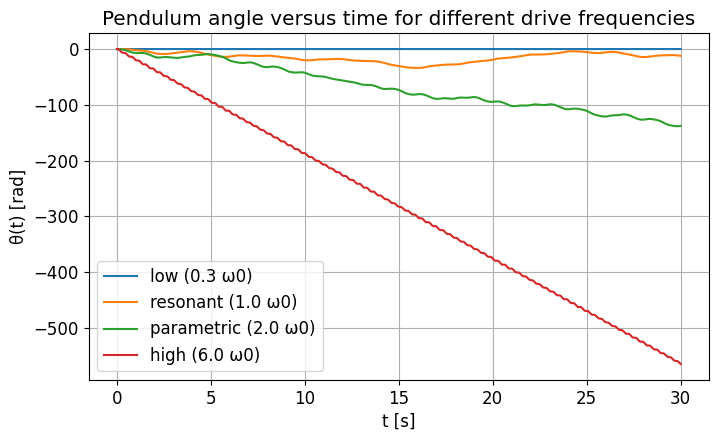

In [7]:

fig, ax = plt.subplots(figsize=(8,4.5))
for label, (sol, params) in solns.items():
    ax.plot(sol.t, sol.y[0], label=label)
ax.set_xlabel('t [s]')
ax.set_ylabel('θ(t) [rad]')
ax.set_title('Pendulum angle versus time for different drive frequencies')
ax.legend()
plt.show()



## Phase portrait (example)
A phase plot for the **resonant** case (\(\omega_d=\omega_0\)).


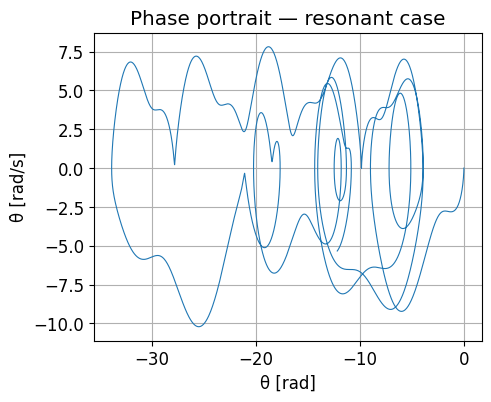

In [8]:

label = "resonant (1.0 ω0)"
sol, params = solns[label]
plt.figure(figsize=(5,4))
plt.plot(sol.y[0], sol.y[1], lw=0.8)
plt.xlabel('θ [rad]')
plt.ylabel('θ̇ [rad/s]')
plt.title('Phase portrait — resonant case')
plt.grid(True)
plt.show()



## Lab-frame trajectory & animation (example)
Below we plot the bob trajectory in the lab frame and create an animation for the **high-frequency** case, which tends to keep the bob near \(\theta\approx 0\) (small excursions).


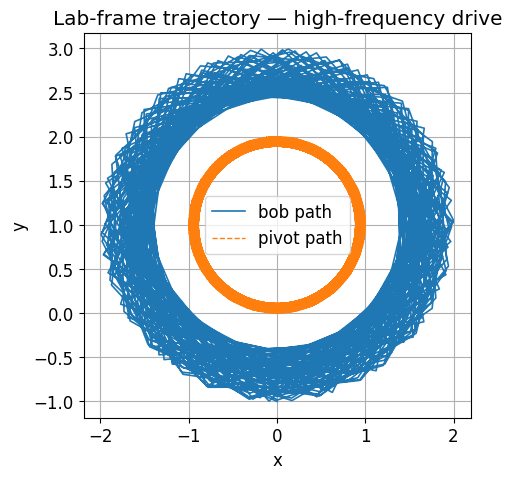

In [9]:

# Choose the high-frequency case for visualization
label = "high (6.0 ω0)"
sol, params = solns[label]

# For animation, downsample a bit
n_points = 600
t_plot = np.linspace(t_min, t_max, n_points)
theta_plot = sol.sol(t_plot)[0]  # requires dense_output=True

# Pivot and bob coordinates
x_pivot, y_pivot = get_pivot_xy(t_plot, params['omega_d'], l=l)
x_rel, y_rel = get_pendulum_xy(t_plot, theta_plot, l=l)
x_lab, y_lab = get_lab_xy(x_pivot, y_pivot, x_rel, y_rel)

# Plot trajectory
plt.figure(figsize=(5,5))
plt.plot(x_lab, y_lab, lw=1.2, label='bob path')
plt.plot(x_pivot, y_pivot, '--', lw=1.0, label='pivot path')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lab-frame trajectory — high-frequency drive')
plt.legend()
plt.show()

# Create an animation object (HTML5 video display in Colab/Jupyter)
anim = create_pendulum_animation(t_plot, x_pivot, y_pivot, x_lab, y_lab, l=l, show_traj=True, speed_factor=4.0)
HTML(anim.to_html5_video())



## Analytic small-angle stability analysis

### Bottom line (answers to the prompts)

- **If the bob starts at rest at \(\theta_0=0\):**  
  - For **very low** drive \((\omega_d\ll\omega_0)\): the motion is quasi-static; the bob moves but remains near vertical with small lag — not perfectly stationary.
  - **Near \(\omega_d\approx\omega_0\):** additive resonance — **unstable/large response** (our simulation shows large \(\theta\)).
  - **Near \(\omega_d\approx2\omega_0\):** parametric resonance bands — **unstable/large response** possible even from \(\theta_0=0\).
  - **For sufficiently high \(\omega_d\gg\omega_0\):** rapid forcing averages out; \(\theta(t)\) stays **small** (nearly stationary bob in the lab frame aside from small oscillations).

- **Stability conditions:**
  - Avoid neighborhoods of \(\omega_d=\omega_0\) and \(\omega_d=2\omega_0\) (and weaker higher-order bands).
  - A conservative instantaneous-stiffness criterion is \(\omega_d^2<g/l\) (so \(k_{\rm eff}(t)>0\) at all times).  
    Even when \(\omega_d^2>g/l\), **fast** drive can still be stable by averaging; numerics are recommended.

These predictions match the numerical experiments below (compare the four regimes).



## Results summary

- **Low (0.3 ω₀):** small, smooth oscillations about 0 — bob not perfectly stationary but remains near equilibrium.
- **Resonant (1.0 ω₀):** large response from additive forcing — near-destabilization (large-amplitude swings).
- **Parametric (2.0 ω₀):** growth consistent with parametric excitation bands — potentially unstable.
- **High (6.0 ω₀):** small excursions — the bob remains nearly stationary; the fast drive averages out.

> You can adjust `l`, `g`, `t_max`, and the `regimes` dictionary to explore thresholds and refine the stability map for your specific setup.
